<a href="https://colab.research.google.com/github/Aleksandra0001/DataScience/blob/main/tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))
x_train.ndim

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


3

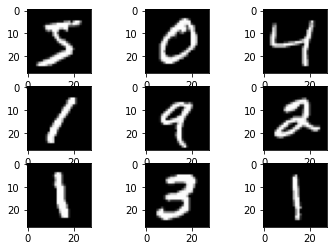

In [5]:
for i in range(9):  
    plt.subplot(3,3, i+1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [7]:
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))
x_train.ndim

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


2

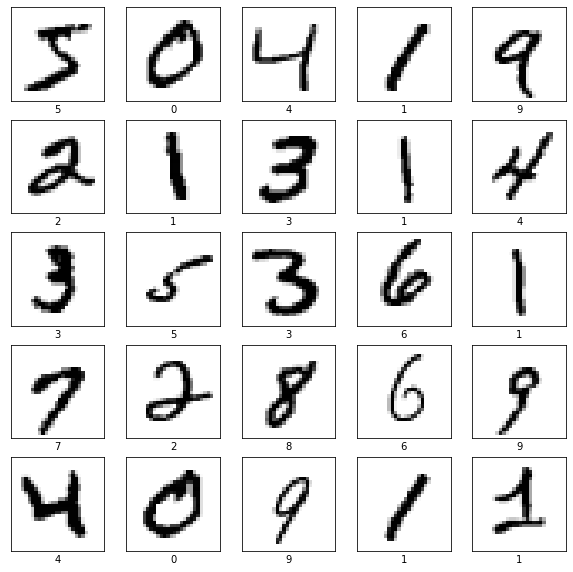

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [9]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="weight")
        self.b = tf.Variable(tf.zeros([out_features]), name="bias")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(num_features, n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Выходной слой
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.out_layer(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    return tf.nn.softmax(x)

In [10]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
   
    # acc = np.sum(np.equal(y_true,y_pred))/len(y_true)
    # return acc
    acc = tf.reduce_sum(tf.cast((y_pred == y_true), tf.float32))
    
    return acc / y_true.shape[0] 

In [11]:
from tensorflow.python.ops.variables import trainable_variables
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)    
    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [12]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        acc = accuracy(np.argmax(pred, axis=1), batch_y)
        accuracy_history.append(acc)

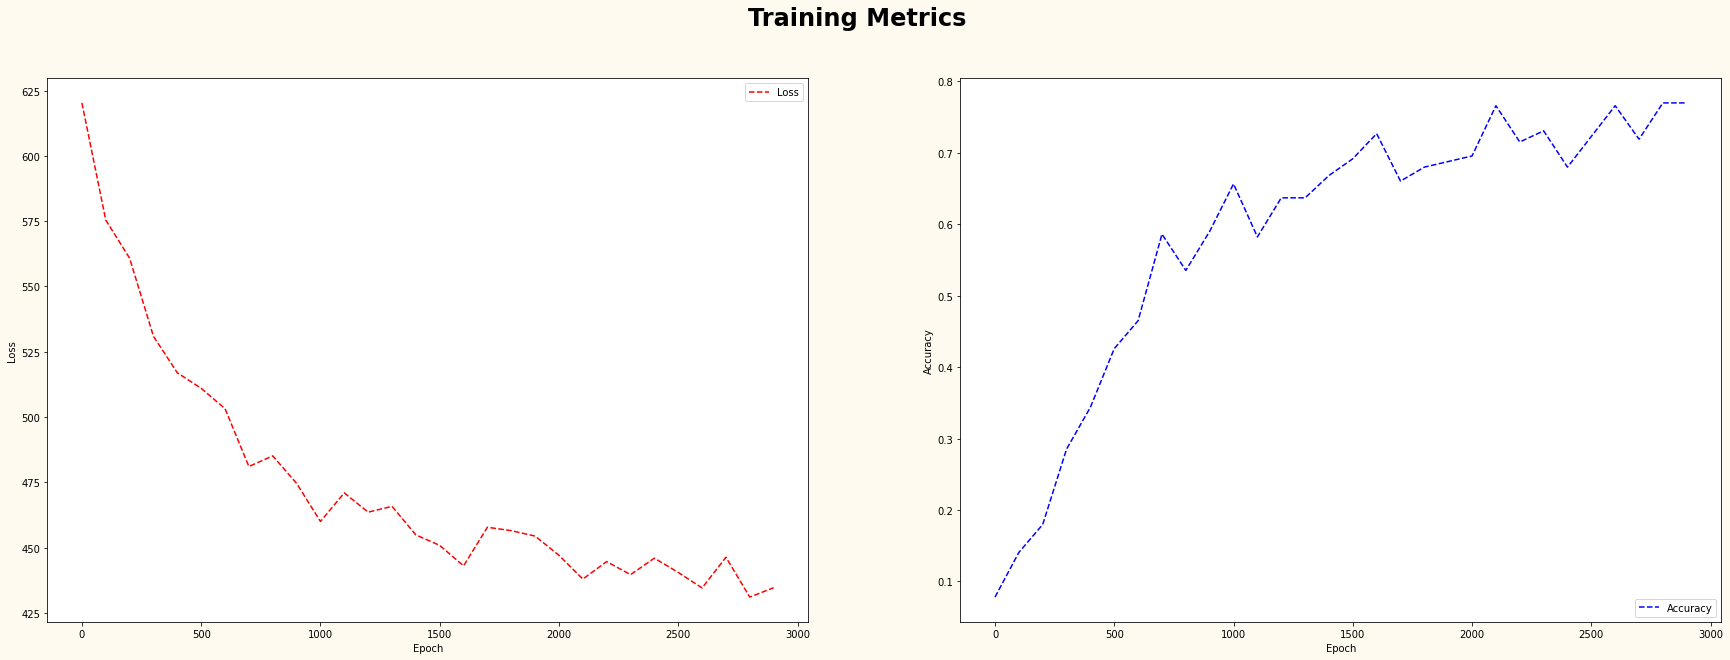

In [13]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
epochs = [i for i in range(0, training_steps, display_step)]
# epochs = np.arange(training_steps)
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('Training Metrics', fontsize=24, fontweight='bold')
fig.set_facecolor('floralwhite')

axes[0].plot(epochs, loss_history, 'r--', label='Loss')
axes[0].legend(loc='upper right')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(epochs, accuracy_history, 'b--', label='Accuracy')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

In [14]:
# Вычислите точность обученной нейросети
acc = accuracy(np.argmax(neural_net(x_test), axis=1), y_test)
print('Test accuracy: %f' % acc)

Test accuracy: 0.751100


Predicted labels: [7 6 1 0 7]
True labels: [7 2 1 0 4]



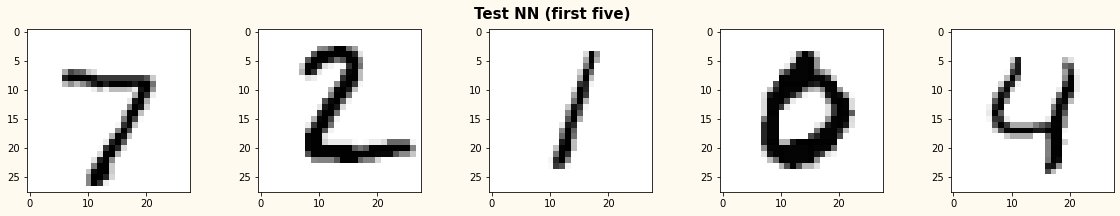

In [15]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

pred = neural_net(x_test[:5])

fig, ax = plt.subplots(1, 5, figsize=(20, 3))
fig.suptitle('Test NN (first five)', fontsize=15, fontweight='bold')
fig.set_facecolor('floralwhite')

print(f'Predicted labels: {np.argmax(pred, axis=1)}')
print(f'True labels: {y_test[:5]}\n')
for i in range(5):
    ax[i].imshow(x_test[i].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

Predicted labels: [2 5 4 5 6]
True labels: [2 3 4 5 6]



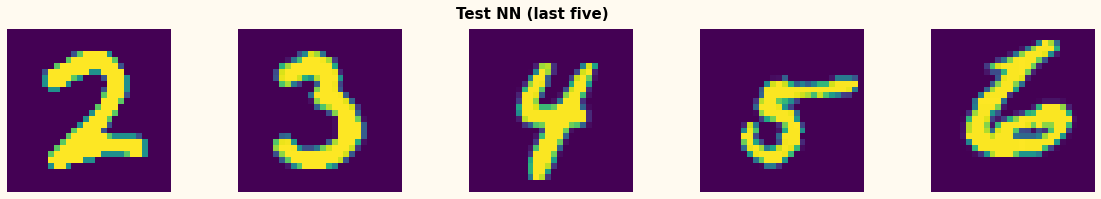

In [16]:
pred = neural_net(x_test[-5:])

fig, ax = plt.subplots(1, 5, figsize=(20, 3))
fig.suptitle('Test NN (last five)', fontsize=15, fontweight='bold')
fig.set_facecolor('floralwhite')

print(f'Predicted labels: {np.argmax(pred, axis=1)}')
print(f'True labels: {y_test[-5:]}\n')

ax = ax.flatten()
for img, axis in zip(x_test[-5:], ax):
    axis.axis('off')
    axis.imshow(img.reshape(28, 28))